In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pydot

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

In [3]:
aapl = yf.Ticker('BRK-A').history(start = '2013-01-01', end = '2023-01-01')
aapl = aapl.drop(columns= ['Dividends', 'Stock Splits'])
aapl.ffill(inplace = True)
aapl.reset_index(inplace = True)

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=aapl.Date,
                      open=aapl.Open,
                      high=aapl.High,
                      low=aapl.Low,
                      close=aapl.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=aapl.Date, y=aapl.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

## LSTM Prediction

In [5]:
lstm_data = aapl.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = scaler.fit_transform(lstm_data)

In [6]:
# Create Training lstm_data
train_length = int(np.ceil(len(lstm_data) * 0.9))
train_data = scaler_data[0:int(train_length), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.        , 0.00235003, 0.00298571, 0.00145156, 0.00347874,
       0.00097605, 0.00540081, 0.00479265, 0.00848412, 0.00899717,
       0.00839402, 0.00969542, 0.00974047, 0.01300148, 0.01491103,
       0.0165603 , 0.01922066, 0.01779413, 0.01723102, 0.01475336,
       0.01567936, 0.01871011, 0.01351453, 0.01805691, 0.01783167,
       0.01664289, 0.0169282 , 0.01557925, 0.01880772, 0.0203719 ,
       0.02410091, 0.02635583, 0.03225467, 0.02850564, 0.0272543 ,
       0.03103086, 0.02575268, 0.02179843, 0.03079811, 0.03250995,
       0.03288535, 0.0333984 , 0.03707736, 0.03875416, 0.03904197,
       0.03954501, 0.04096404, 0.03687965, 0.03959506, 0.04099407,
       0.03476237, 0.03411417, 0.03243737, 0.03450459, 0.03351102,
       0.03536552, 0.03547313, 0.04028831, 0.03759041, 0.04171985])]
[0.039149585804740095]

[array([0.        , 0.00235003, 0.00298571, 0.00145156, 0.00347874,
       0.00097605, 0.00540081, 0.00479265, 0.00848412, 0.00899717,
       0.00839402, 0.00969542, 0.0

In [7]:
## Model construction
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)




2207/2207 [==============================] - 20s 9ms/step - loss: 0.0018


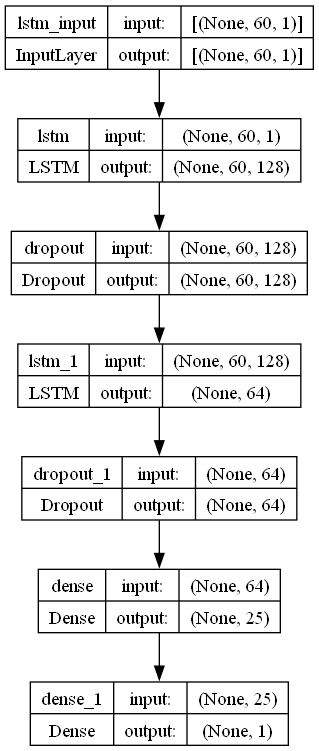

In [8]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [9]:
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaler_data[train_length - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = lstm_data[train_length:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
print(f'mean_squared_error = {mean_squared_error(predictions, y_test)}')
print(f'mean_absolute_error = {mean_absolute_error(predictions, y_test)}')

8/8 [==============================] - 1s 15ms/step
mean_squared_error = 112548467.90497385
mean_absolute_error = 8409.73580677291


In [10]:
predicted_prices = aapl.loc[train_length:].copy()
predicted_prices['Pred_Close'] = predictions

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=aapl.Date, y=aapl.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Pred_Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Pred_Close,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

## XGBoost

In [11]:
xg_data = yf.Ticker('AAPL').history(start = '2013-01-01', end = '2023-01-01')
xg_data.reset_index(inplace=True)

In [12]:
xg_data['open-close'] = xg_data['Open'] - xg_data['Close']
xg_data['high-low'] = xg_data['High'] - xg_data['Low']

intervals = [5, 30, 60, 252]
for interval in intervals:
    xg_data[f'ema{interval}'] = xg_data['Close'] / xg_data['Close'].ewm(span = interval).mean()
    xg_data[f'ave{interval}'] = xg_data['Close'] / xg_data['Close'].rolling(interval, min_periods = 1).mean()

delta = xg_data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down
xg_data['RSI'] = 100 - (100 / (1 + rs))

exp1 = xg_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = xg_data['Close'].ewm(span=26, adjust=False).mean()
xg_data['MACD'] = exp1 - exp2

xg_data['norm_vol'] = xg_data['Volume'] / xg_data['Volume'].ewm(5).mean()
xg_data['vol_change'] = xg_data['Volume'].pct_change()
xg_data['Target'] = xg_data['Close'].shift(-1)

xg_data.replace([np.inf, -np.inf], 0, inplace = True)
xg_data = xg_data.dropna(how = 'any', axis= 0)
xg_data = xg_data.drop(columns= ['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
xg_data.head()

,Date,Close,open-close,high-low,ema5,ave5,ema30,ave30,ema60,ave60,ema252,ave252,RSI,MACD,norm_vol,vol_change,Target
1,2013-01-03 00:00:00-05:00,16.557428,0.176539,0.264809,0.994913,0.993649,0.993859,0.993649,0.993754,0.993649,0.993674,0.993649,0.000000,-0.016885,0.789089,-0.370287,16.096228
2,2013-01-04 00:00:00-05:00,16.096228,0.304515,0.390953,0.982464,0.977054,0.977945,0.977054,0.977498,0.977054,0.977159,0.977054,0.000000,-0.066712,1.175800,0.683831,16.001545
3,2013-01-07 00:00:00-05:00,16.001545,-0.058032,0.430657,0.986236,0.978324,0.979699,0.978324,0.979013,0.978324,0.978488,0.978324,0.000000,-0.112543,0.971012,-0.185379,16.044607
4,2013-01-08 00:00:00-05:00,16.044607,0.119118,0.324978,0.993126,0.984708,0.986299,0.984708,0.985510,0.984708,0.984900,0.984708,1.484284,-0.143733,0.940955,-0.052564,15.793846
5,2013-01-09 00:00:00-05:00,15.793846,0.164932,0.275500,0.985671,0.981062,0.976446,0.974300,0.975380,0.974300,0.974558,0.974300,1.357889,-0.186536,0.871932,-0.111406,15.989640


In [13]:
test_size  = 0.1
valid_size = 0.1

test_split_idx  = int(xg_data.shape[0] * (1-test_size))
valid_split_idx = int(xg_data.shape[0] * (1-(valid_size+test_size)))

train_df  = xg_data.loc[:valid_split_idx].copy()
valid_df  = xg_data.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = xg_data.loc[test_split_idx+1:].copy()

drop_cols = ['Date']
train_df = train_df.drop(columns= drop_cols)
valid_df = valid_df.drop(columns= drop_cols)
test_df  = test_df.drop(columns= drop_cols)

In [14]:
y_train = train_df['Target'].copy()
X_train = train_df.drop(columns = ['Target'])

y_valid = valid_df['Target'].copy()
X_valid = valid_df.drop(columns= ['Target'])

y_test  = test_df['Target'].copy()
X_test  = test_df.drop(columns= ['Target'])

In [15]:
# parameters = {
#     'n_estimators': [100, 200, 300, 400],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05],
#     'max_depth': [10, 12, 15],
#     'gamma': [0.001, 0.005, 0.01, 0.02],
#     'random_state': [42]
# }

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [10],
    'gamma': [0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=10)
clf = GridSearchCV(model, parameters)
fit_params = {'eval_set': eval_set, 'verbose': False}
clf.fit(X_train, y_train, **fit_params)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.8026516676187103


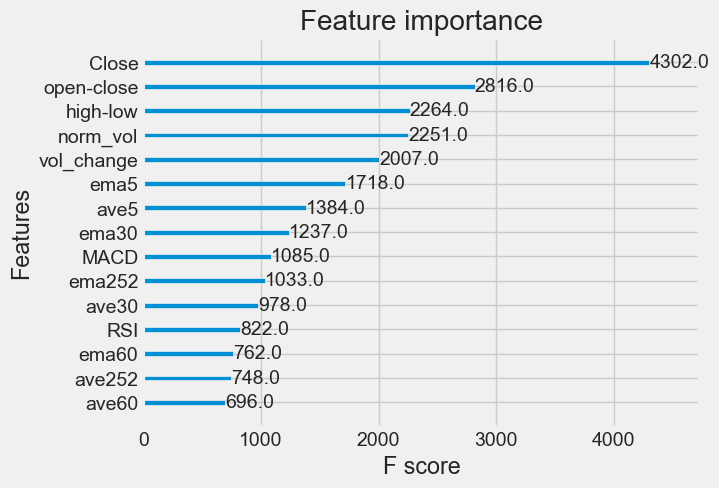

In [16]:
model = clf.best_estimator_
plot_importance(model)
plt.show()

In [17]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
print(f'mean_absolute_error = {mean_absolute_error(y_test, y_pred)}')

y_true = [175.56402588 179.95388794 177.66998291 172.94398499 170.05697632]
y_pred = [129.49477 130.18475 130.05055 130.16481 120.69467]
mean_squared_error = 751.8526170632923
mean_absolute_error = 24.473781858171737


In [18]:
predicted_prices = xg_data.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=xg_data.Date, y=xg_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()